In [1]:
#importing the needed librabries for this work
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import  image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import os,warnings, random,shutil
warnings.filterwarnings('ignore')
import codecs
codecs.register_error("strict",codecs.ignore_errors)
from tensorflow.keras.applications import ResNet50,EfficientNetB3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [3]:
#mounting my google drive inside my workspace
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


importing packages needed for image classifcation

This project aims to leverage deep learning for automatic garbage classification, sorting waste into ten distinct categories: **Metal, Glass, Biological Waste, Paper, Battery Waste, General Trash, Cardboard, Shoes, Clothes, and Plastic**. The objective is to develop a reliable image classification model capable of identifying waste items based on their visual characteristics. This system can enhance waste management efficiency and encourage more effective recycling practices.

1. Importing Required Libraries  
2. Dataset Loading  
3. Image Visualization  
4. Preprocessing Images  
5. Model Development  
   - **EfficientNetB3**  
   - **5.1 EfficientNetB3: Compilation & Training**  
6. ResNet50 Model  
   - **6.1 ResNet50: Compilation & Training**  
7. Convolutional Neural Network (CNN)  
   - **7.1 CNN: Compilation & Training**  
8. Model Performance Comparison (Accuracy & Loss)  
9. Making Predictions  
10. Predicting the First Class  
11. Conclusion & Acknowledgment

In [4]:
#loading of the dataset by specifiying the path on the drive
data_path= data_path = "/content/drive/MyDrive/garbage-dataset"
classes_names =os.listdir(data_path)
classes_names

['plastic',
 'clothes',
 'battery',
 'paper',
 'cardboard',
 'trash',
 'metal',
 'shoes',
 'glass',
 'biological']

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os  # Import the os module for interacting with the file system

# Define the base output directory where data folders will be created
out_dir = '/colab/working/'

# Define the paths for training, validation, and testing directories
train_dir = os.path.join(out_dir, 'train')
valid_dir = os.path.join(out_dir, 'valid')
test_dir = os.path.join(out_dir, 'test')

# Create each directory if it does not already exist
for folder in [train_dir, valid_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)
    # `exist_ok=True` ensures no error is raised if the folder already exists


In [7]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split

# Define dataset split ratios
train_size = 0.7
validation_size = 0.15
test_ratio = 0.15

# Loop through each class folder
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)

    # Skip if not a directory
    if not os.path.isdir(class_path):
        continue

    # List image files
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))]

    # Skip if not enough images to split
    if len(image_files) < 3:
        print(f"Skipping class '{class_name}' due to insufficient images ({len(image_files)}).")
        continue

    # Shuffle
    random.shuffle(image_files)

    # Split into train and temp (valid + test)
    train_imgs, temp_imgs = train_test_split(
        image_files,
        test_size=(1 - train_size),
        random_state=42
    )

    # Only split temp if it has more than 1 image
    if len(temp_imgs) > 1:
        valid_imgs, test_imgs = train_test_split(
            temp_imgs,
            test_size=(test_ratio / (test_ratio + validation_size)),
            random_state=42
        )
    else:
        # If only 1 image in temp, assign to validation and leave test empty
        valid_imgs, test_imgs = temp_imgs, []

    # Create destination folders
    for folder in [train_dir, valid_dir, test_dir]:
        os.makedirs(os.path.join(folder, class_name), exist_ok=True)

    # Copy images to respective folders
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in valid_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(valid_dir, class_name, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))


IMAGE VISUALZATION IN A RANDOM STATE

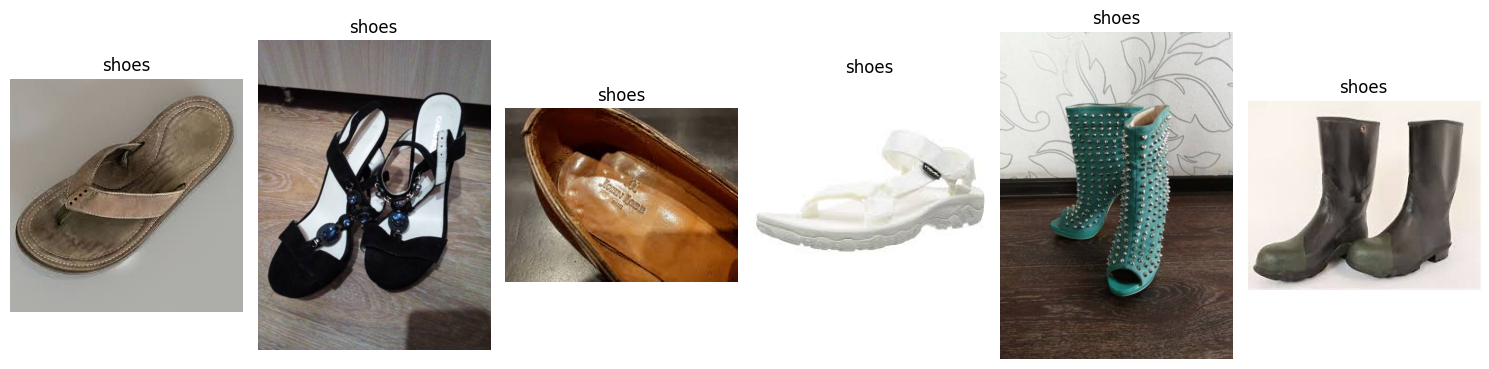

In [8]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image


# Get list of classes (folders in dataset)
classes = [cls for cls in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, cls))]

# Set number of images to display
num_images = 6

# Randomly pick a class
selected_class = random.choice(classes)
class_path = os.path.join(data_path, selected_class)

# Get list of images in the selected class
image_files = [img for img in os.listdir(class_path) if img.endswith(('.jpg', '.png', '.jpeg'))]

# Randomly select images
selected_images = random.sample(image_files, min(num_images, len(image_files)))

# Plot the images
fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 5))

for ax, img_name in zip(axes, selected_images):
    img_path = os.path.join(class_path, img_name)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(selected_class)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [9]:
# Create an image data generator for the training set
# We're using a ResNet-specific preprocessing function (scales pixels appropriately)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # Prepares images in a way that matches ResNet expectations
)

# Create another image data generator for validation and test sets
# No augmentation is applied here; only preprocessing
valid_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Load and prepare the training dataset from folders
train_generator = train_datagen.flow_from_directory(
    train_dir,                # Path to training data folder
    target_size=(224, 224),   # Resize all images to 224x224 (ResNet input size)
    batch_size=100,           # Number of images per batch
    class_mode='categorical'  # Because it's multi-class classification (10 classes), we use one-hot encoded labels
)

# Load and prepare the validation dataset
valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir,                # Path to validation data folder
    target_size=(224, 224),   # Resize to match training input size
    batch_size=100,           # Number of images per batch
    class_mode='categorical'  # One-hot encoded labels
)

# Load and prepare the test dataset
test_generator = valid_test_datagen.flow_from_directory(
    test_dir,                 # Path to test data folder
    target_size=(224, 224),   # Resize to match input size
    batch_size=1,             # One image at a time (often used for precise evaluation or prediction)
    class_mode=None,          # No labels since we're only predicting
    shuffle=False,            # Keep order consistent for evaluation (important when matching filenames to predictions)
    seed=123                  # Set a seed for reproducibility
)


Found 13844 images belonging to 10 classes.
Found 2969 images belonging to 10 classes.
Found 2974 images belonging to 10 classes.


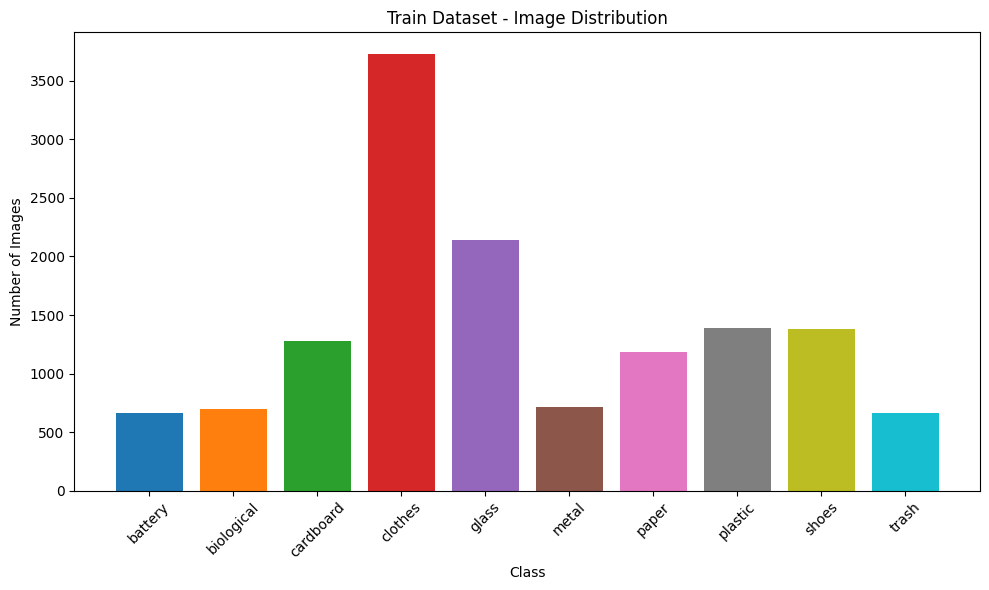

In [10]:
import os
import matplotlib.pyplot as plt

# Count images in each class
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Sort class names alphabetically for consistency
sorted_classes = sorted(class_counts.items())
class_names = [cls[0] for cls in sorted_classes]
class_values = [cls[1] for cls in sorted_classes]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_values, color=plt.cm.tab10.colors[:len(class_names)])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Train Dataset - Image Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


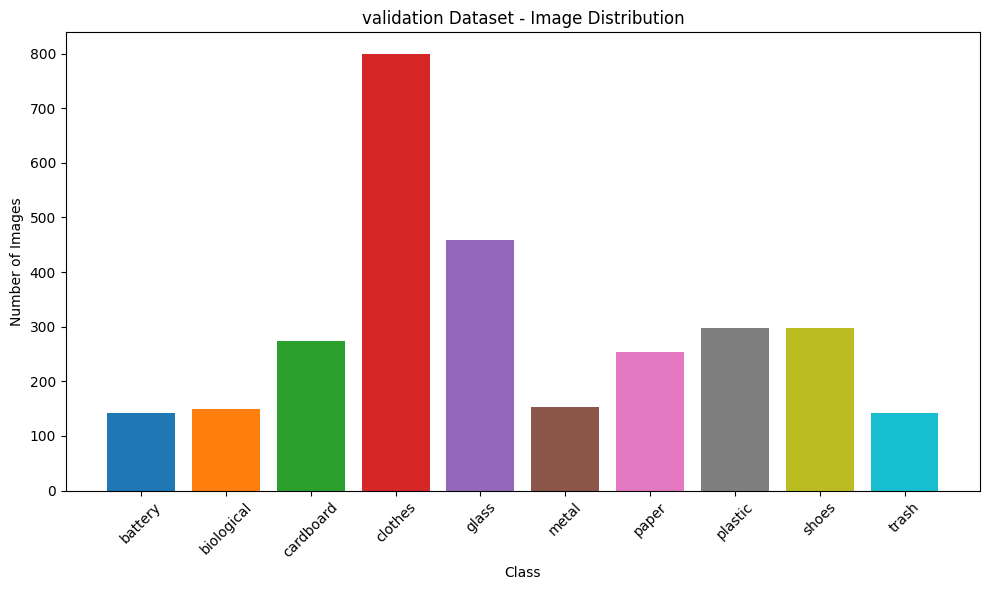

In [11]:
import os
import matplotlib.pyplot as plt

# Count images in each class
class_counts = {}
for class_name in os.listdir(valid_dir):
    class_path = os.path.join(valid_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Sort class names alphabetically for consistency
sorted_classes = sorted(class_counts.items())
class_names = [cls[0] for cls in sorted_classes]
class_values = [cls[1] for cls in sorted_classes]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_values, color=plt.cm.tab10.colors[:len(class_names)])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("validation Dataset - Image Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


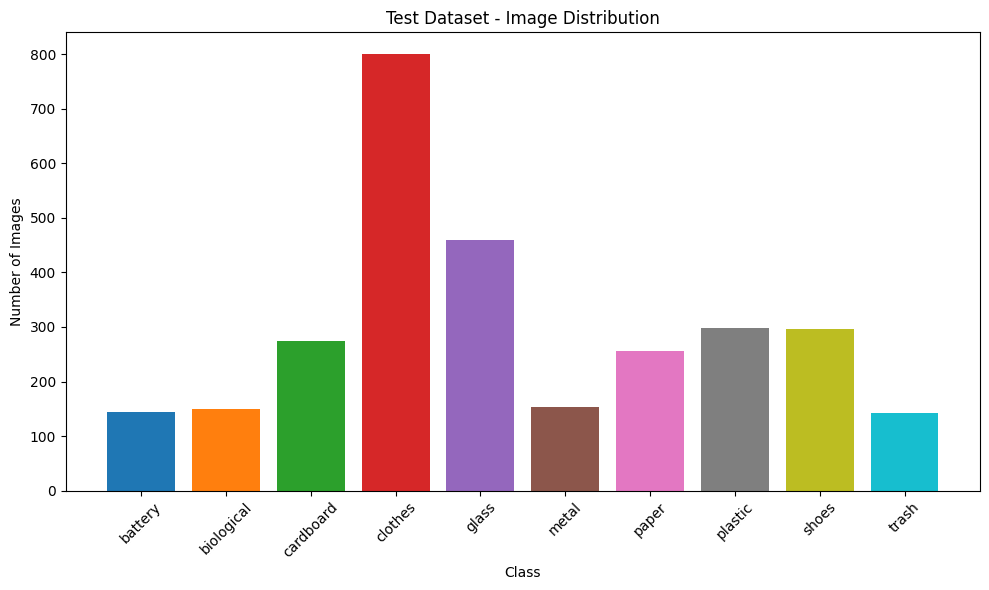

In [12]:
import os
import matplotlib.pyplot as plt

# Count images in each class
class_counts = {}
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Sort class names alphabetically for consistency
sorted_classes = sorted(class_counts.items())
class_names = [cls[0] for cls in sorted_classes]
class_values = [cls[1] for cls in sorted_classes]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_values, color=plt.cm.tab10.colors[:len(class_names)])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Test Dataset - Image Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
class_labels=train_generator.class_indices
print(class_labels)

{'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}


In [14]:
# Load the EfficientNetB3 model as the base
# We're removing the top (fully connected) layers so we can add our own
# 'pooling=avg' means we'll apply global average pooling to the final convolutional output
# 'weights=imagenet' means we're using pre-trained weights from ImageNet
base_model = EfficientNetB3(include_top=False, pooling='avg', weights='imagenet')

# Freeze the entire base model so its weights don't get updated during training
# This allows us to retain the powerful features learned from ImageNet
base_model.trainable = False

# Add custom layers on top of the base model for our specific classification task
x = Dense(128, activation='relu')(base_model.output)  # First custom dense layer
x = Dense(64, activation='relu')(x)                   # Second custom dense layer
output_layer = Dense(10, activation='softmax')(x)     # Output layer for 10 classes using softmax

# Create the full model by connecting the base model's input to our custom output layer
model_1 = Model(inputs=base_model.input, outputs=output_layer)

# Print a summary of the entire model architecture
model_1.summary()



43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          7 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, None,      │          0 │ normalization[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │      1,080 │ stem_conv_pad[0]… │
│                     │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 40)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        960 │ block1a_se_excit

 Total params: 10,989,177 (41.92 MB)

 Trainable params: 205,642 (803.29 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [16]:
#complie our model for training
#selected our optimizer to be rmsprop
#selected our loss to br categorical crossentropy for muti class classification
#selected our metrics based pon accuracy
model_1.compile(optimizer='Rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
#implemnting early stop callback to select the best epoch during the training by monitoring the validation loss
early_stop=EarlyStopping(monitor='val_loss',patience=10)
checkpoint=ModelCheckpoint(filepath='/colab/working/best.keras',monitor='val_loss',save_best_only=True,mode='auto')

In [18]:
# Train the model using the training and validation data generators
history_1 = model_1.fit(
    train_generator,                            # Training data generator
    steps_per_epoch=train_generator.samples // 100,  # Number of batches per epoch (total samples divided by batch size)
    validation_data=valid_generator,            # Validation data generator
    validation_steps=valid_generator.samples // 100,  # Number of validation batches per epoch
    epochs=10,                                  # Total number of epochs to train
    callbacks=[early_stop, checkpoint]          # List of callbacks: early stopping and model checkpointing
)


Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 144s 748ms/step - accuracy: 0.5192 - loss: 2.2387 - val_accuracy: 0.6924 - val_loss: 0.9879
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.7400 - loss: 1.3787 - val_accuracy: 0.7028 - val_loss: 0.9442
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 73s 529ms/step - accuracy: 0.7009 - loss: 1.4794 - val_accuracy: 0.7462 - val_loss: 0.8290
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.6600 - loss: 0.8825 - val_accuracy: 0.7338 - val_loss: 0.8582
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 143s 631ms/step - accuracy: 0.7359 - loss: 1.1150 - val_accuracy: 0.7486 - val_loss: 0.7796
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.7600 - loss: 0.7711 - val_accuracy: 0.7376 - val_loss: 0.7932
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 70s 503ms/step - accuracy: 0.7479 - loss: 0.8835 - val_accuracy: 0.7586 - val_loss: 0.7619
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.8400 - loss: 0

In [54]:
# saving the model
model_1.save("my_model.keras")  # creates a .keras file

# HDF5 format
model_1.save("my_model_1.h5")     # creates a .h5 file


In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get the true labels and predicted labels
y_true = test_generator.classes
y_pred = model_1.predict(test_generator, verbose=0)

# for multi class classification
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[ 94   5  13  12  12   1   2   0   4   1]
 [  6  82   0  28  11   0   1   2  17   3]
 [  5   5 217  21  11   2   8   2   2   1]
 [  1   6   3 752   7   1   6   2  16   6]
 [  5  12   3  31 361   7   1  12  28   0]
 [  5   5   2  18  12 105   0   3   3   1]
 [  1   5  22  21   5   1 186   2   9   3]
 [  1   8   7  24  42   5   4 189  10   8]
 [  7   8   2  42  12   2   2   0 219   3]
 [  0   1   2  12   9   5   4   5   3 101]]


In [20]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming y_true is the true labels and y_pred are the predicted probabilities
y_pred_prob = model_1.predict(test_generator, verbose=0)

# For multiclass classification, convert probabilities to predicted class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Ensure y_true is in the correct format and the classes are correct
y_true = test_generator.classes

# Generate classification report
ClassificationReport = classification_report(y_true, y_pred, target_names=["Metal", "Glass", "Biological Waste", "Paper",
                                                                          "Battery Waste", "General Trash", "Cardboard", "Shoes",
                                                                          "Clothes", "Plastic"])

# Print the classification report
print('Classification Report:\n', ClassificationReport)


Classification Report:
                   precision    recall  f1-score   support

           Metal       0.75      0.65      0.70       144
           Glass       0.60      0.55      0.57       150
Biological Waste       0.80      0.79      0.80       274
           Paper       0.78      0.94      0.85       800
   Battery Waste       0.75      0.78      0.77       460
   General Trash       0.81      0.68      0.74       154
       Cardboard       0.87      0.73      0.79       255
           Shoes       0.87      0.63      0.73       298
         Clothes       0.70      0.74      0.72       297
         Plastic       0.80      0.71      0.75       142

        accuracy                           0.78      2974
       macro avg       0.77      0.72      0.74      2974
    weighted avg       0.78      0.78      0.77      2974



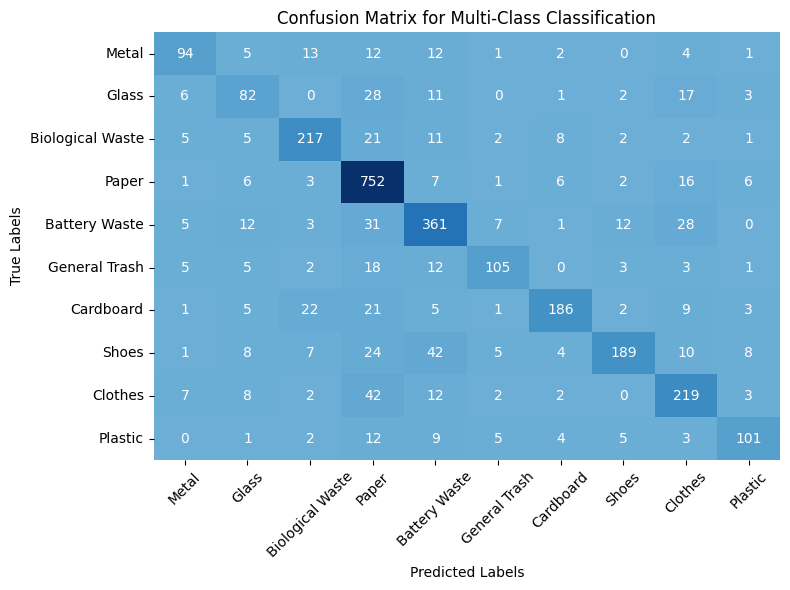

Confusion Matrix:
 [[ 94   5  13  12  12   1   2   0   4   1]
 [  6  82   0  28  11   0   1   2  17   3]
 [  5   5 217  21  11   2   8   2   2   1]
 [  1   6   3 752   7   1   6   2  16   6]
 [  5  12   3  31 361   7   1  12  28   0]
 [  5   5   2  18  12 105   0   3   3   1]
 [  1   5  22  21   5   1 186   2   9   3]
 [  1   8   7  24  42   5   4 189  10   8]
 [  7   8   2  42  12   2   2   0 219   3]
 [  0   1   2  12   9   5   4   5   3 101]]


In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# get the  confusion matrix
CM = confusion_matrix(y_true, y_pred)

# Define class labels to ensure accurate class names
class_names = ["Metal", "Glass", "Biological Waste", "Paper", "Battery Waste",
               "General Trash", "Cardboard", "Shoes", "Clothes", "Plastic"]
#set the figsize and plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(CM, fmt='g', annot=True, cmap='Blues', cbar=False, center=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Multi-Class Classification')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print('Confusion Matrix:\n', CM)


model building resnet50

In [22]:
#Load the base model without the top layer
resnet_model_base = ResNet50(include_top=False, pooling='avg', weights='imagenet')

# Freeze the base model
resnet_model_base.trainable = False

# Add new layers
x = Dense(128, activation='relu')(resnet_model_base.output)
x = Dense(64, activation='relu')(x)
output_layer = Dense(10, activation='softmax')(x)  # Adjust output neurons as needed

#  the new model
model_2 = Model(inputs=resnet_model_base.input, outputs=output_layer)

#  model summary
model_2.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,858,890 (91.01 MB)

 Trainable params: 271,178 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [23]:
early_stop=EarlyStopping(monitor='val_loss',patience=10)
cheackpoint=ModelCheckpoint(filepath='/colab/working/best.keras',monitor='val_loss',save_best_only=True,mode='auto')

In [24]:

model_2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [25]:
history_2=model_2.fit(
           train_generator,
           steps_per_epoch=train_generator.samples//100,
           validation_data=valid_generator,
           validation_steps=valid_generator.samples//100,
           epochs=10,
           callbacks=[early_stop,cheackpoint]



)

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 102s 616ms/step - accuracy: 0.7878 - loss: 0.6601 - val_accuracy: 0.9310 - val_loss: 0.2208
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.9300 - loss: 0.2156 - val_accuracy: 0.9303 - val_loss: 0.2292
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 110s 552ms/step - accuracy: 0.9567 - loss: 0.1456 - val_accuracy: 0.9410 - val_loss: 0.1901
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9773 - loss: 0.1154 - val_accuracy: 0.9379 - val_loss: 0.1921
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 122s 547ms/step - accuracy: 0.9752 - loss: 0.0795 - val_accuracy: 0.9334 - val_loss: 0.2006
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.9600 - loss: 0.1328 - val_accuracy: 0.9345 - val_loss: 0.2013
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 142s 648ms/step - accuracy: 0.9824 - loss: 0.0527 - val_accuracy: 0.9328 - val_loss: 0.2139
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.9900 - loss: 

Building CNN

In [52]:
# saving the model
model_2.save("my_model.keras")  # creates a .keras file

# HDF5 format
model_2.save("my_model_2.h5")     # creates a .h5 file


In [26]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get the true labels and predicted labels
y_true = test_generator.classes
y_pred = model_2.predict(test_generator, verbose=0)  # Predictions from the model

# np.argmax for multi class classification
y_pred_labels = np.argmax(y_pred, axis=1)

# get the confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[139   0   1   0   0   2   0   1   0   1]
 [  0 145   0   0   0   0   0   2   1   2]
 [  1   1 259   0   2   1   8   1   1   0]
 [  0   0   0 793   0   0   0   0   7   0]
 [  0   1   0   2 424   7   2  20   2   2]
 [  2   1   0   3   8 135   1   2   0   2]
 [  1   2   6   6   0   1 235   3   0   1]
 [  1   2   5   0  12   5   2 267   1   3]
 [  0   1   0  14   0   0   0   0 281   1]
 [  0   1   0   3   2   3   2   6   1 124]]


In [27]:
from sklearn.metrics import classification_report
import numpy as np

# predicting the test dataset assuming the y pred as true vs the actual
y_pred_prob = model_2.predict(test_generator, verbose=0)

# For multiclass classification, convert probabilities to predicted class labels
y_pred = np.argmax(y_pred_prob, axis=1)

#  getting the generator classes and ensuring they are in the right format
y_true = test_generator.classes

# Generate classification report
ClassificationReport = classification_report(y_true, y_pred, target_names=["Metal", "Glass", "Biological Waste", "Paper",
                                                                          "Battery Waste", "General Trash", "Cardboard", "Shoes",
                                                                          "Clothes", "Plastic"])

# Print the classification report
print('Classification Report:\n', ClassificationReport)


Classification Report:
                   precision    recall  f1-score   support

           Metal       0.97      0.97      0.97       144
           Glass       0.94      0.97      0.95       150
Biological Waste       0.96      0.95      0.95       274
           Paper       0.97      0.99      0.98       800
   Battery Waste       0.95      0.92      0.93       460
   General Trash       0.88      0.88      0.88       154
       Cardboard       0.94      0.92      0.93       255
           Shoes       0.88      0.90      0.89       298
         Clothes       0.96      0.95      0.95       297
         Plastic       0.91      0.87      0.89       142

        accuracy                           0.94      2974
       macro avg       0.93      0.93      0.93      2974
    weighted avg       0.94      0.94      0.94      2974



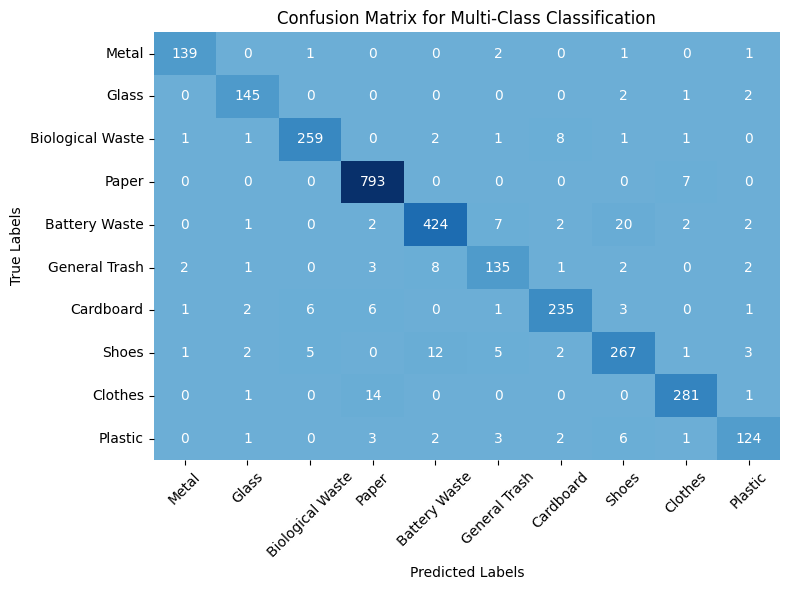

Confusion Matrix:
 [[139   0   1   0   0   2   0   1   0   1]
 [  0 145   0   0   0   0   0   2   1   2]
 [  1   1 259   0   2   1   8   1   1   0]
 [  0   0   0 793   0   0   0   0   7   0]
 [  0   1   0   2 424   7   2  20   2   2]
 [  2   1   0   3   8 135   1   2   0   2]
 [  1   2   6   6   0   1 235   3   0   1]
 [  1   2   5   0  12   5   2 267   1   3]
 [  0   1   0  14   0   0   0   0 281   1]
 [  0   1   0   3   2   3   2   6   1 124]]


In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# get the confusion matrix
CM = confusion_matrix(y_true, y_pred)

# the class labels across the ten categories my dataset
class_names = ["Metal", "Glass", "Biological Waste", "Paper", "Battery Waste",
               "General Trash", "Cardboard", "Shoes", "Clothes", "Plastic"]
#setting the figsize and plotting the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(CM, fmt='g', annot=True, cmap='Blues', cbar=False, center=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Multi-Class Classification')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print('Confusion Matrix:\n', CM)


In [30]:
model_3=Sequential()

In [31]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from keras.regularizers import l2

# Define the input layer
input_layer = Input(shape=(224, 224, 3))

# First layer
x = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

# Second layer
x = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

# Third layer
x = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully Connected Layer
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)

# Output Layer (10 classes)
output_layer = Dense(10, activation='softmax')(x)

# Create the model
model_3 = Model(inputs=input_layer, outputs=output_layer)



In [32]:
# Compile the model
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,946 (437.29 KB)

 Trainable params: 111,498 (435.54 KB)

 Non-trainable params: 448 (1.75 KB)

In [34]:
history_3=model_3.fit(train_generator,epochs=15,validation_data=valid_generator,verbose=1,)

Epoch 1/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 80s 573ms/step - accuracy: 0.3694 - loss: 4.0680 - val_accuracy: 0.4237 - val_loss: 2.9248
Epoch 2/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 71s 508ms/step - accuracy: 0.4797 - loss: 2.5183 - val_accuracy: 0.4874 - val_loss: 2.1142
Epoch 3/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 71s 508ms/step - accuracy: 0.5078 - loss: 1.9647 - val_accuracy: 0.5217 - val_loss: 1.8527
Epoch 4/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 67s 482ms/step - accuracy: 0.5249 - loss: 1.7283 - val_accuracy: 0.5035 - val_loss: 1.6795
Epoch 5/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 69s 498ms/step - accuracy: 0.5605 - loss: 1.5667 - val_accuracy: 0.4769 - val_loss: 1.7412
Epoch 6/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 70s 501ms/step - accuracy: 0.5725 - loss: 1.5059 - val_accuracy: 0.4995 - val_loss: 1.6736
Epoch 7/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 71s 512ms/step - accuracy: 0.6096 - loss: 1.4149 - val_accuracy: 0.5103 - val_loss: 1.7064
Epoch 8/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 69s 495ms/step - accuracy: 0.6240 - loss: 1

In [51]:
# saving the model
model_3.save("my_model.keras")  # creates a .keras file

# HDF5 format
model_3.save("my_model_3.h5")     # creates a .h5 file


In [35]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get the true labels and predicted labels
y_true = test_generator.classes
y_pred = model_3.predict(test_generator, verbose=0)

# np.argmax for multiclass classification.
y_pred_label = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_label)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[ 84   0   1  11   6   1   9   3  27   2]
 [  1  97   3  17  12   0   3   1  13   3]
 [ 17   2 167  16  22   0  25  11  12   2]
 [  2   4   0 729  16   1  11   8  24   5]
 [  7   3   2   9 372   8   4  22  30   3]
 [ 11   5   4  15  40  45   6   3  21   4]
 [  2   1   6  43  32   5 142   8  11   5]
 [  7   2  11  33  62   5   7 145   7  19]
 [ 12   8   0  46  30   2   7   3 187   2]
 [  5   1   2  10  29  11   2  12   2  68]]


In [36]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming y_true is the true labels and y_pred are the predicted probabilities
y_pred_probability = model_3.predict(test_generator, verbose=0)

# np.argmax to connvert probablities in multi class classification.
y_pred = np.argmax(y_pred_probability, axis=1)

y_true = test_generator.classes

# Generate classification report
ClassificationReport = classification_report(y_true, y_pred, target_names=["Metal", "Glass", "Biological Waste", "Paper",
                                                                          "Battery Waste", "General Trash", "Cardboard", "Shoes",
                                                                          "Clothes", "Plastic"])

# Print the classification report
print('Classification Report:\n', ClassificationReport)


Classification Report:
                   precision    recall  f1-score   support

           Metal       0.57      0.58      0.58       144
           Glass       0.79      0.65      0.71       150
Biological Waste       0.85      0.61      0.71       274
           Paper       0.78      0.91      0.84       800
   Battery Waste       0.60      0.81      0.69       460
   General Trash       0.58      0.29      0.39       154
       Cardboard       0.66      0.56      0.60       255
           Shoes       0.67      0.49      0.56       298
         Clothes       0.56      0.63      0.59       297
         Plastic       0.60      0.48      0.53       142

        accuracy                           0.68      2974
       macro avg       0.67      0.60      0.62      2974
    weighted avg       0.69      0.68      0.68      2974



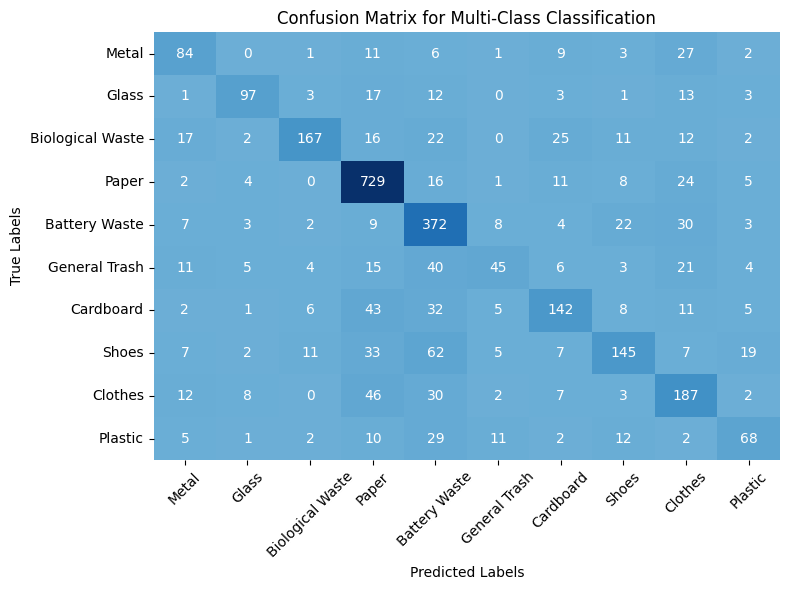

Confusion Matrix:
 [[ 84   0   1  11   6   1   9   3  27   2]
 [  1  97   3  17  12   0   3   1  13   3]
 [ 17   2 167  16  22   0  25  11  12   2]
 [  2   4   0 729  16   1  11   8  24   5]
 [  7   3   2   9 372   8   4  22  30   3]
 [ 11   5   4  15  40  45   6   3  21   4]
 [  2   1   6  43  32   5 142   8  11   5]
 [  7   2  11  33  62   5   7 145   7  19]
 [ 12   8   0  46  30   2   7   3 187   2]
 [  5   1   2  10  29  11   2  12   2  68]]


In [37]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# get the  confusion matrix
CM = confusion_matrix(y_true, y_pred)

# class names of our classes across ten categories
class_names = ["Metal", "Glass", "Biological Waste", "Paper", "Battery Waste",
               "General Trash", "Cardboard", "Shoes", "Clothes", "Plastic"]
#plotting the confusion matrix values
plt.figure(figsize=(8, 6))
sns.heatmap(CM, fmt='g', annot=True, cmap='Blues', cbar=False, center=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Multi-Class Classification')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print('Confusion Matrix:\n', CM)


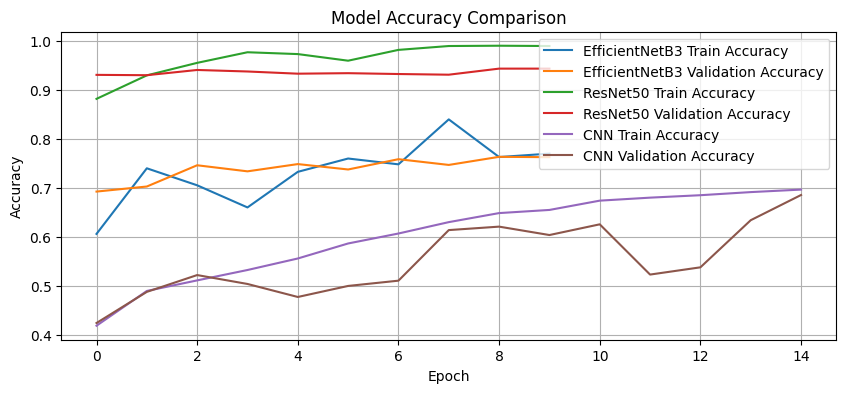

In [38]:
plt.figure(figsize=(10, 4))



#   EfficientNetB3
plt.plot(history_1.history['accuracy'], label='EfficientNetB3 Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='EfficientNetB3 Validation Accuracy')

# ResNet50
plt.plot(history_2.history['accuracy'], label='ResNet50 Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='ResNet50 Validation Accuracy')

# Convolution
plt.plot(history_3.history['accuracy'], label='CNN Train Accuracy')
plt.plot(history_3.history['val_accuracy'], label='CNN Validation Accuracy')

plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


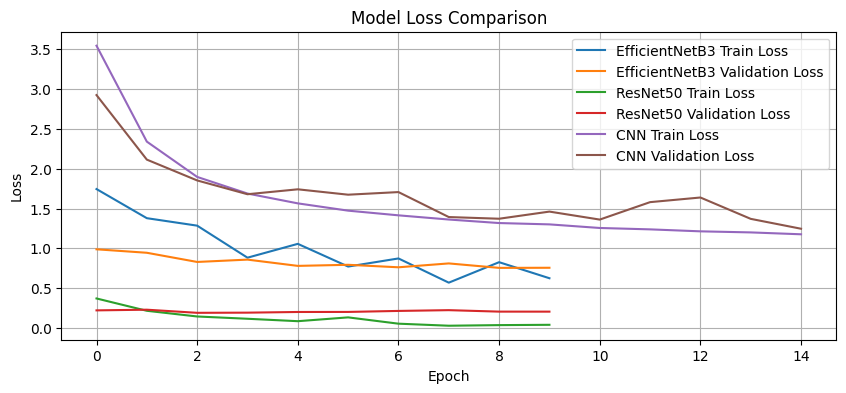

In [39]:
plt.figure(figsize=(10, 4))

# EfficientNetB3
plt.plot(history_1.history['loss'], label='EfficientNetB3 Train Loss')
plt.plot(history_1.history['val_loss'], label='EfficientNetB3 Validation Loss')


# ResNet50
plt.plot(history_2.history['loss'], label='ResNet50 Train Loss')
plt.plot(history_2.history['val_loss'], label='ResNet50 Validation Loss')

# Convolution
plt.plot(history_3.history['loss'], label='CNN Train Loss')
plt.plot(history_3.history['val_loss'], label='CNN Validation Loss')

plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Predictions EfficientNB

In [40]:
prediction=model_1.predict(test_generator,steps=len(test_generator),verbose=1)
pred_classes_indecies_11=np.argmax(prediction,axis=1)

2974/2974 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step


In [41]:
class_labels=list(train_generator.class_indices.keys())
class_labels

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

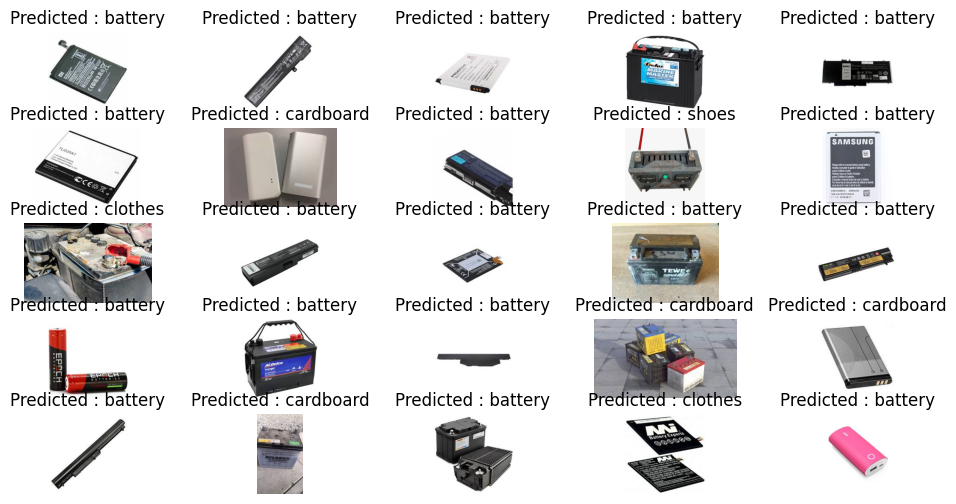

In [42]:
fig,ax=plt.subplots(5,5,figsize=(12,6))
for i in range(25):  # Loop through first 25 images
    img_path = os.path.join(test_dir, test_generator.filenames[i])  # Correct full path
    img = load_img(img_path)  # Load image

    predicted_class = class_labels[pred_classes_indecies_11[i]]

    ax[i//5 , i%5].imshow(img)
    ax[i//5 , i%5].axis('off')
    ax[i//5 , i%5].set_title(f"Predicted : {predicted_class}")

Prediction Resnet50

In [43]:
prediction=model_2.predict(test_generator,steps=len(test_generator),verbose=1)
pred_classes_indecies=np.argmax(prediction,axis=1)

2974/2974 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step


In [44]:
class_labels=list(train_generator.class_indices.keys())
class_labels

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

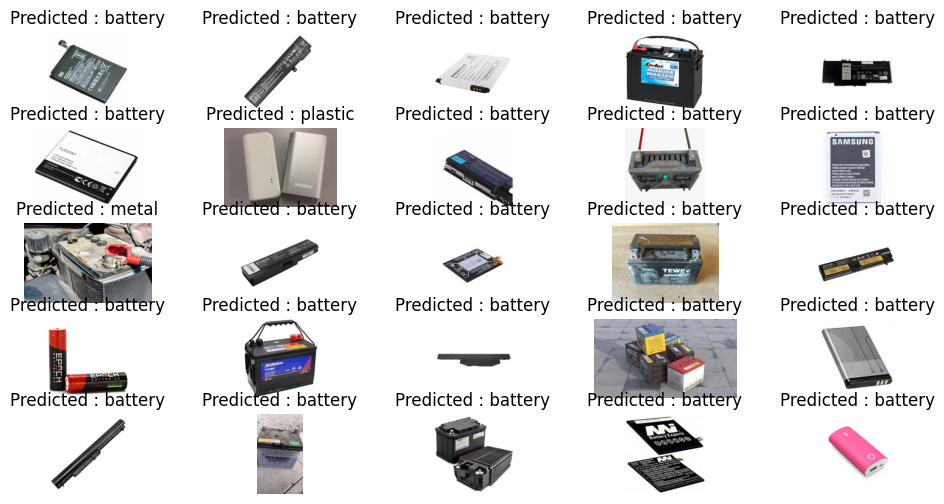

In [46]:
fig,ax=plt.subplots(5,5,figsize=(12,6))
for i in range(25):  # Loop through first 25 images
    img_path = os.path.join(test_dir, test_generator.filenames[i])  # Correct full path
    img = load_img(img_path)  # Load image

    predicted_class = class_labels[pred_classes_indecies[i]]

    ax[i//5 , i%5].imshow(img)
    ax[i//5 , i%5].axis('off')
    ax[i//5 , i%5].set_title(f"Predicted : {predicted_class}")

Prediction CNN

In [47]:
pred=model_3.predict(test_generator,steps=len(test_generator),verbose=1)
pred_classes_indecies_3=np.argmax(pred,axis=1)

2974/2974 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step


In [48]:
class_labels=list(train_generator.class_indices.keys())
class_labels

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

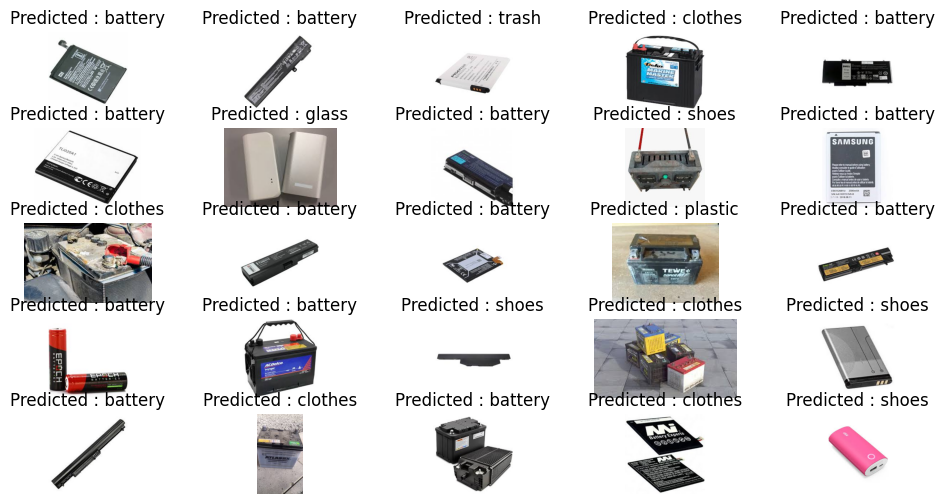

In [49]:
fig,ax=plt.subplots(5,5,figsize=(12,6))
for i in range(25):  # Loop through first 25 images
    img_path = os.path.join(test_dir, test_generator.filenames[i])  # Correct full path
    img = load_img(img_path)  # Load image

    predicted_class = class_labels[pred_classes_indecies_3[i]]

    ax[i//5 , i%5].imshow(img)
    ax[i//5 , i%5].axis('off')
    ax[i//5 , i%5].set_title(f"Predicted : {predicted_class}")